# Cell 1: Install & Import Necessary Libraries

In [1]:
# Install necessary libraries
#!pip install transformers torch pandas scikit-learn matplotlib seaborn numpy wordcloud

# Import libraries
import os
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

# RoBERTa-specific imports (replacing BERT)
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification
# Updated imports for optimizer and scheduler
from torch.optim import AdamW
from transformers.optimization import get_linear_schedule_with_warmup

# Cell 2: Load the Dataset

In [2]:
# Load the resume.csv file
df = pd.read_csv("f:\\CSE499A,B\\New 499B\\final works\\graph generation\\Datasets\\Resume\\Resume.csv")

# Display the first few rows
df.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


# Cell 3: Check for Missing Data & Basic Info

In [3]:
# Check for missing values
print(df.isnull().sum())

# Display dataset information
df.info()

# Drop rows with missing values (if any)
df.dropna(inplace=True)


ID             0
Resume_str     0
Resume_html    0
Category       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           2484 non-null   int64 
 1   Resume_str   2484 non-null   object
 2   Resume_html  2484 non-null   object
 3   Category     2484 non-null   object
dtypes: int64(1), object(3)
memory usage: 77.8+ KB


# Cell 4: Advanced Text Preprocessing Function

In [4]:
def preprocess_text_for_bert(text):
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # BERT will handle the rest of tokenization
    return text

# Apply minimal preprocessing to 'resume_str'
df['processed_resume'] = df['Resume_str'].apply(preprocess_text_for_bert)

# Display sample processed text
df[['Resume_str', 'processed_resume']].head()

,Resume_str,processed_resume
0,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR ADMINISTRATOR/MARKETING ASSOCIATE HR ADMINI...
1,"HR SPECIALIST, US HR OPERATIONS ...","HR SPECIALIST, US HR OPERATIONS Summary Versat..."
2,HR DIRECTOR Summary Over 2...,HR DIRECTOR Summary Over 20 years experience i...
3,HR SPECIALIST Summary Dedica...,"HR SPECIALIST Summary Dedicated, Driven, and D..."
4,HR MANAGER Skill Highlights ...,HR MANAGER Skill Highlights HR SKILLS HR Depar...


# Cell 5: Data Visualization (Optional - needs WordCloud import)


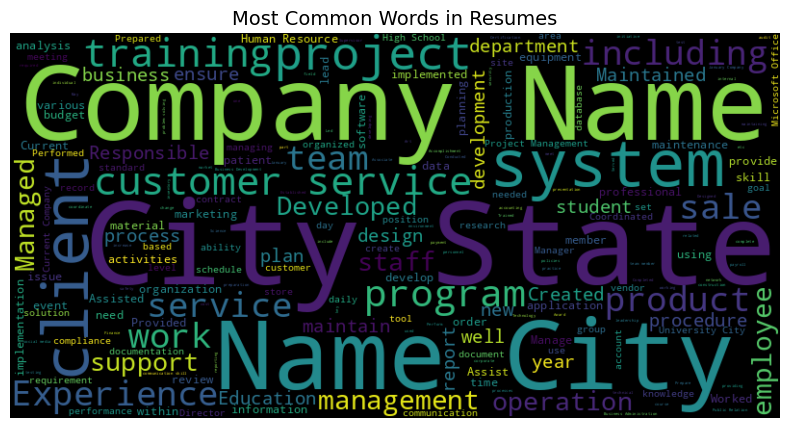

In [5]:
from wordcloud import WordCloud

# Generate a WordCloud to visualize frequent words
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(' '.join(df['processed_resume']))

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Resumes", fontsize=14)
plt.show()

# Cell 6: Convert Categories to Numeric Labels

In [6]:
# Encode categories into numeric labels
label_encoder = LabelEncoder()
df['Category_label'] = label_encoder.fit_transform(df['Category'])

# Display mapping of labels
category_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Category mapping:")
for category, label in category_mapping.items():
    print(f"{category}: {label}")

Category mapping:
ACCOUNTANT: 0
ADVOCATE: 1
AGRICULTURE: 2
APPAREL: 3
ARTS: 4
AUTOMOBILE: 5
AVIATION: 6
BANKING: 7
BPO: 8
BUSINESS-DEVELOPMENT: 9
CHEF: 10
CONSTRUCTION: 11
CONSULTANT: 12
DESIGNER: 13
DIGITAL-MEDIA: 14
ENGINEERING: 15
FINANCE: 16
FITNESS: 17
HEALTHCARE: 18
HR: 19
INFORMATION-TECHNOLOGY: 20
PUBLIC-RELATIONS: 21
SALES: 22
TEACHER: 23


# Cell 7: Train-Test Split

In [7]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df['processed_resume'], 
    df['Category_label'], 
    test_size=0.2, 
    random_state=42, 
    stratify=df['Category_label']
)

# Print dataset shapes
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

Training samples: 1987, Testing samples: 497


# Cell 8: Create BERT Dataset and DataLoader

In [8]:
# Load RoBERTa tokenizer (replacing BERT tokenizer)
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Maximum sequence length for RoBERTa
MAX_LEN = 256

class ResumeDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        
        # Tokenize and prepare for RoBERTa
        encoding = tokenizer(
            text,
            truncation=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Create datasets
train_dataset = ResumeDataset(X_train, y_train)
test_dataset = ResumeDataset(X_test, y_test)

# Create dataloaders
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Created RoBERTa datasets with {len(train_dataset)} training and {len(test_dataset)} testing samples")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\USER\.cache\huggingface\hub\models--roberta-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Created RoBERTa datasets with 1987 training and 497 testing samples


# Cell 9: Updated Model Initialization  and Train RoBERTA Model

Using device: cuda


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/20
Average training loss: 2.9837
Average validation loss: 2.3207
Saved best model to roberta_resume_best_model

Epoch 2/20
Average training loss: 1.8275
Average validation loss: 1.2947
Saved best model to roberta_resume_best_model

Epoch 3/20
Average training loss: 1.1828
Average validation loss: 0.9146
Saved best model to roberta_resume_best_model

Epoch 4/20
Average training loss: 0.9134
Average validation loss: 0.7489
Saved best model to roberta_resume_best_model

Epoch 5/20
Average training loss: 0.7392
Average validation loss: 0.6128
Saved best model to roberta_resume_best_model

Epoch 6/20
Average training loss: 0.6344
Average validation loss: 0.5311
Saved best model to roberta_resume_best_model

Epoch 7/20
Average training loss: 0.5474
Average validation loss: 0.4467
Saved best model to roberta_resume_best_model

Epoch 8/20
Average training loss: 0.4760
Average validation loss: 0.3671
Saved best model to roberta_resume_best_model

Epoch 9/20
Average training loss: 0.424

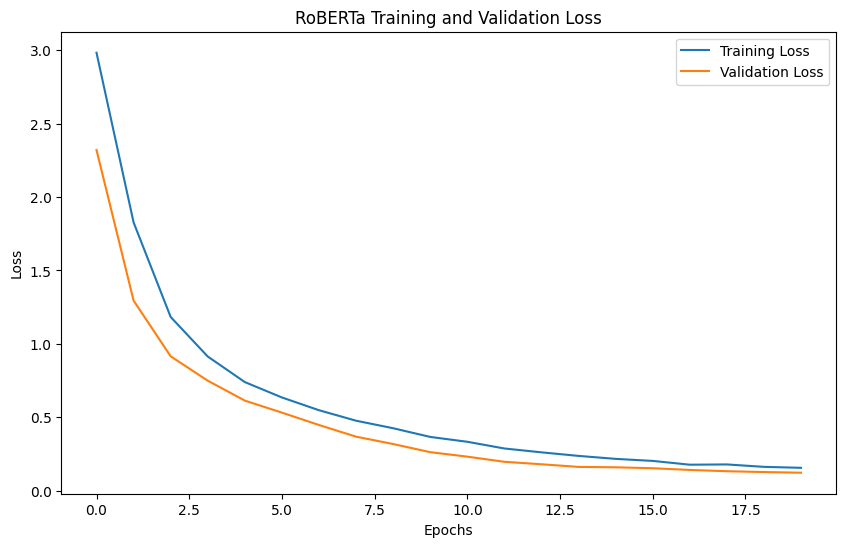

In [9]:
# Cell 9 (updated): Initialize and Train RoBERTa Model with more epochs
# Set device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize RoBERTa model (replacing BERT)
num_classes = len(df['Category_label'].unique())
model = RobertaForSequenceClassification.from_pretrained(
    'roberta-base',
    num_labels=num_classes
)
model.to(device)

# Set up optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=1e-5)  # Slightly lower learning rate for RoBERTa
epochs = 20

# Total steps for scheduler
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# For early stopping
best_val_loss = float('inf')
patience = 3
early_stop_counter = 0
val_losses = []
train_losses = []

# Split training data into train and validation
train_texts, val_texts, train_labels, val_labels = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42
)

# Create validation dataset and dataloader
val_dataset = ResumeDataset(val_texts, val_labels)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

# Training loop
for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    
    # Training phase
    model.train()
    total_train_loss = 0
    
    for batch in train_dataloader:
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        # Zero gradients
        model.zero_grad()
        
        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        total_train_loss += loss.item()
        
        # Backward pass
        loss.backward()
        
        # Clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # Update parameters
        optimizer.step()
        scheduler.step()
    
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f"Average training loss: {avg_train_loss:.4f}")
    
    # Validation phase
    model.eval()
    total_val_loss = 0
    
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            total_val_loss += loss.item()
    
    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    print(f"Average validation loss: {avg_val_loss:.4f}")
    
    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
        # Save the best model
        best_model_path = "roberta_resume_best_model"
        model.save_pretrained(best_model_path)
        print(f"Saved best model to {best_model_path}")
    else:
        early_stop_counter += 1
        print(f"Early stopping counter: {early_stop_counter}/{patience}")
        
    if early_stop_counter >= patience:
        print("Early stopping triggered")
        break

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('RoBERTa Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Cell 10: Evaluate the BERT Model

Accuracy: 0.8068
Classification Report as Table:


,precision,recall,f1-score,support
ACCOUNTANT,1.00,0.96,0.98,24.00
ADVOCATE,0.75,0.88,0.81,24.00
AGRICULTURE,0.57,0.62,0.59,13.00
APPAREL,0.29,0.21,0.24,19.00
ARTS,0.44,0.52,0.48,21.00
AUTOMOBILE,0.50,0.57,0.53,7.00
AVIATION,0.75,0.62,0.68,24.00
BANKING,0.71,0.65,0.68,23.00
BPO,0.33,0.25,0.29,4.00
BUSINESS-DEVELOPMENT,0.96,1.00,0.98,24.00


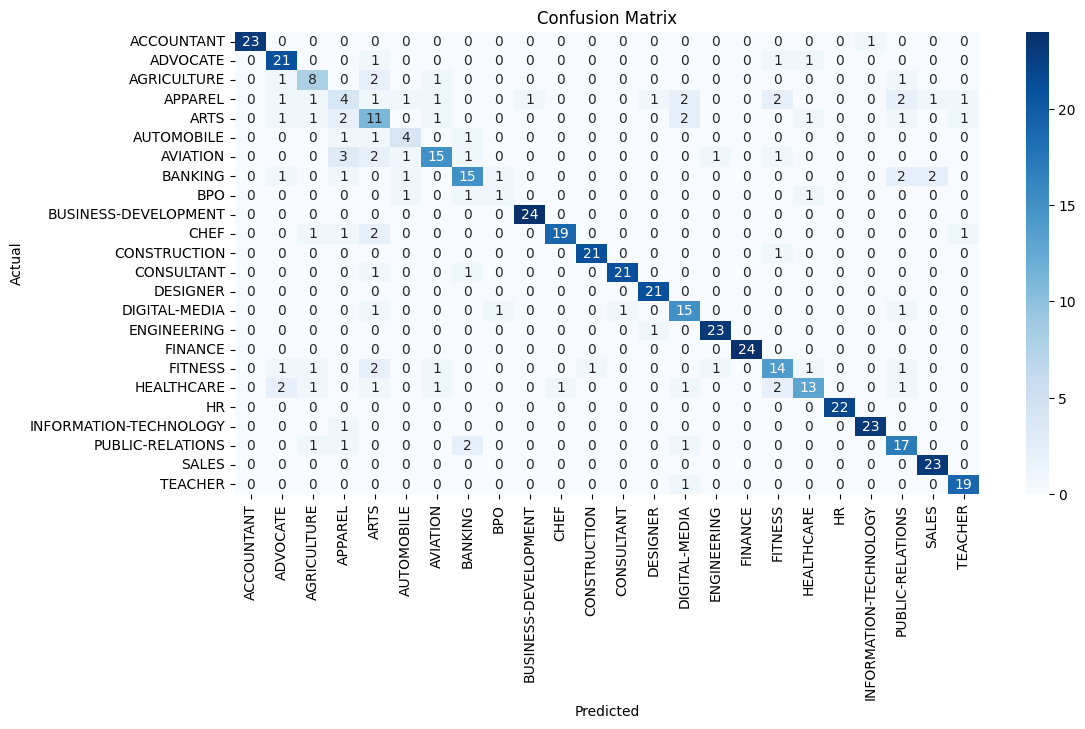

In [10]:
# Evaluation
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        # Get predictions
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        
        # Store predictions and true labels
        predictions.extend(preds)
        true_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy:.4f}")

# Classification Report
# Enhanced Classification Report (replaces the simple print in Cell 10)
from sklearn.metrics import classification_report

# Get the classification report as a dictionary
report = classification_report(true_labels, predictions, 
                              target_names=label_encoder.classes_, 
                              output_dict=True)

# Convert to DataFrame for better visualization
report_df = pd.DataFrame(report).transpose()

# Apply styling to the DataFrame
styled_report = report_df.style.background_gradient(cmap='Blues', subset=pd.IndexSlice[:, ['precision', 'recall', 'f1-score']])\
                               .format(precision=2)

# Display the styled report
print("Classification Report as Table:")
display(styled_report)

# If display() doesn't work in your environment, use this instead:
# print(report_df.round(2).to_string())

# Confusion Matrix
plt.figure(figsize=(12, 6))
sns.heatmap(confusion_matrix(true_labels, predictions), annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Cell 11: Precision, Recall, F1-score

In [11]:
# Calculate precision, recall, and F1-score
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

# Print metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.8054
Recall: 0.8068
F1 Score: 0.8032


# Cell 12: Enhanced Evaluation Metrics

In [12]:
# New Cell: Additional Performance Metrics
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score, roc_auc_score
from sklearn.preprocessing import label_binarize

# Calculate additional metrics
mcc = matthews_corrcoef(true_labels, predictions)
kappa = cohen_kappa_score(true_labels, predictions)

# For ROC-AUC in multi-class setting
classes = np.unique(true_labels)
y_bin = label_binarize(true_labels, classes=classes)
y_pred_proba = torch.nn.functional.softmax(torch.tensor(model(
    input_ids=test_dataloader.dataset[0]['input_ids'].unsqueeze(0).to(device),
    attention_mask=test_dataloader.dataset[0]['attention_mask'].unsqueeze(0).to(device)
).logits.detach().cpu()), dim=1).numpy()

try:
    roc_auc = roc_auc_score(y_bin, y_pred_proba, multi_class='ovr')
    print(f"ROC-AUC Score (OvR): {roc_auc:.4f}")
except:
    print("ROC-AUC calculation requires predicted probabilities for all samples.")

print(f"Matthews Correlation Coefficient: {mcc:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")

# Per-class metrics
per_class_precision = precision_score(true_labels, predictions, average=None)
per_class_recall = recall_score(true_labels, predictions, average=None)
per_class_f1 = f1_score(true_labels, predictions, average=None)

# Create DataFrame for per-class metrics
class_metrics_df = pd.DataFrame({
    'Class': label_encoder.classes_,
    'Precision': per_class_precision,
    'Recall': per_class_recall,
    'F1-Score': per_class_f1
})

print("\nPer-Class Metrics:")
print(class_metrics_df.to_string(index=False))

ROC-AUC calculation requires predicted probabilities for all samples.
Matthews Correlation Coefficient: 0.7982
Cohen's Kappa: 0.7979

Per-Class Metrics:
                 Class  Precision   Recall  F1-Score
            ACCOUNTANT   1.000000 0.958333  0.978723
              ADVOCATE   0.750000 0.875000  0.807692
           AGRICULTURE   0.571429 0.615385  0.592593
               APPAREL   0.285714 0.210526  0.242424
                  ARTS   0.440000 0.523810  0.478261
            AUTOMOBILE   0.500000 0.571429  0.533333
              AVIATION   0.750000 0.625000  0.681818
               BANKING   0.714286 0.652174  0.681818
                   BPO   0.333333 0.250000  0.285714
  BUSINESS-DEVELOPMENT   0.960000 1.000000  0.979592
                  CHEF   0.950000 0.791667  0.863636
          CONSTRUCTION   0.954545 0.954545  0.954545
            CONSULTANT   0.954545 0.913043  0.933333
              DESIGNER   0.913043 1.000000  0.954545
         DIGITAL-MEDIA   0.681818 0.789474  0.731707

C:\Users\USER\AppData\Local\Temp\ipykernel_10012\2328198840.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_proba = torch.nn.functional.softmax(torch.tensor(model(


# Cell 13: Misclassification Analysis

In [13]:
# New Cell: Misclassification Analysis
# Find misclassified examples
misclassified_indices = np.where(np.array(predictions) != np.array(true_labels))[0]

# Sample up to 10 misclassified examples
sample_size = min(10, len(misclassified_indices))
sampled_indices = np.random.choice(misclassified_indices, sample_size, replace=False)

print(f"\nMisclassification Analysis (Showing {sample_size} examples):")
for idx in sampled_indices:
    actual_label = label_encoder.inverse_transform([true_labels[idx]])[0]
    predicted_label = label_encoder.inverse_transform([predictions[idx]])[0]
    
    # Get the corresponding text from the test set
    text_idx = X_test.index[idx]
    text = X_test.iloc[idx][:100] + "..."  # Show first 100 chars
    
    print(f"\nExample {idx}:")
    print(f"Text: {text}")
    print(f"Actual: {actual_label}")
    print(f"Predicted: {predicted_label}")
    print("-" * 50)


Misclassification Analysis (Showing 10 examples):

Example 280:
Text: BRANCH BANKER III Accomplishments Maximize sales volume. Maintain visual presentation standards that...
Actual: BANKING
Predicted: SALES
--------------------------------------------------

Example 178:
Text: SR. FREELANCE DESIGNER/PRODUCT DEVELOPMENT MANAGER Summary Product Development Manager/Sr. Designer ...
Actual: APPAREL
Predicted: DESIGNER
--------------------------------------------------

Example 442:
Text: ASSISTANT TO CFO Professional Summary Dedicated and focused Office Administrator who excels at prior...
Actual: AVIATION
Predicted: APPAREL
--------------------------------------------------

Example 340:
Text: GROCERY CLERK Experience Grocery Clerk , 07/2012 to 05/2014 Company Name – City , State Used pallet ...
Actual: APPAREL
Predicted: ARTS
--------------------------------------------------

Example 232:
Text: PROJECT MANAGER Summary Technical Support Professional skilled at resolving complex customer

# Cell 14: Save the Model (Optional)


In [14]:
# Save the model
model_path = "roberta_resume_classifier_model"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)
print(f"RoBERTa model saved to {model_path}")

RoBERTa model saved to roberta_resume_classifier_model
